# Read WWW for various car data
and create lqlite3 database

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import sqlite3
import re
from datetime import datetime, timedelta
from collections import OrderedDict
import time

import sqlalchemy as sa


strCarSalesQ=r'https://auto.vercity.ru/statistics/sales/europe/{year}/{country}/01-12/'
strCarProdsQ=r'https://auto.vercity.ru/statistics/production/europe/{year}/{country}/01-12/'

#conn=sqlite3.connect('cars.sqlite3') #connect or create database
eng_co=sa.create_engine('sqlite+pysqlite:///cars.sqlite3') #, echo=True)

In [2]:
class CarDataFrame(pd.DataFrame):

    @property
    def _constructor(self):
        return CarDataFrame

    def to_datetime(self, strField='date', format='%b-%Y'):
        self[strField]=pd.to_datetime(self[strField], format=format)
        return self
    
    def to_sql(self, name, con, flavor='sqlite', schema=None, if_exists='fail', index=True,
               index_label=None, chunksize=10, dtype=None):

        def drop_table(strTName):
            meta=sa.MetaData(bind=con)
            try:
                tbl_=sa.Table(strTName, meta, autoload=True, autoload_with=con)
                tbl_.drop(con, checkfirst=False)
            except:
                pass
        
        def create_table(strTName, strDateName='date', strModelName='Model', strCountName='Count'):
            metadata=sa.MetaData(bind=con)
            bname_t=sa.Table(strTName, metadata,
                        sa.Column(strDateName, sa.String, primary_key=True, nullable=False, autoincrement=False),
                        sa.Column(strModelName, sa.String, primary_key=True, nullable=False, autoincrement=False),
                        sa.Column(strCountName, sa.Float, primary_key=False, nullable=False, autoincrement=False))
            metadata.create_all()

        def buff_insert(alch_table, insert_prefix, values, buff_size=chunksize):
            def iterate_group(iterator, count):
                itr=iter(iterator)
                for i in range(0, len(iterator), count):
                    yield iterator[i:i+count]
        
            for i in iterate_group(values, buff_size):
                
                inserter = alch_table.insert(prefixes=insert_prefix, values=i)
                con.execute(inserter)
             
        if if_exists=='replace':
            drop_table(name)
            if_exists='fail'
        
        if not con.dialect.has_table(con, name):
            create_table(name)
            
        meta=sa.MetaData(bind=con)
        tbl_names=sa.Table(name, meta, autoload=True, autoload_with=con)
        vals=self.to_dict(orient='records')

        inserter=None

        if flavor == 'mysql':
            if if_exists in ['append', 'ignore']:
                inserter = tbl_names.insert(prefixes=['IGNORE'], values=vals)
            elif if_exists in ['update', 'upsert']:
                ins_state = sa.dialects.mysql.insert(tbl_names).values(vals)
                inserter = ins_state.on_duplicate_key_update(Date=ins_state.inserted.Date)
            elif if_exists=='fail':
                inserter = tbl_names.insert(values=vals)
            con.execute(inserter)
                
        if flavor == 'sqlite':
            if if_exists in ['append', 'ignore']:
                #inserter = tbl_names.insert(prefixes=['OR IGNORE'], values=vals)
                buff_insert(tbl_names, ['OR IGNORE'], vals, buff_size=chunksize)
            elif if_exists in ['update', 'upsert']:
                buff_insert(tbl_names, ['OR REPLACE'], vals, buff_size=chunksize)
                #inserter = tbl_names.insert(prefixes=['OR REPLACE'], values=vals)
            elif if_exists=='fail':
                buff_insert(tbl_names, None, vals, buff_size=chunksize)
        


In [3]:
startYear=2010
endYear=datetime.now().year+1

update_behaviour='upsert'

def get_date_list(iYear):
        dates=['{0}-01-01'.format(iYear), '{0}-01-01'.format(iYear+1)]
        start, end=[datetime.strptime(_, '%Y-%m-%d') for _ in dates]
        od=OrderedDict(((start+timedelta(_)).strftime(r'%b-%Y'), None) for _ in range((end-start).days))
        return list(od.keys())

def GetYearsSalesData(curYear, strSource=strCarSalesQ, country='russia'):
    print('Reading from ', strSource.format(year=curYear, country=country), end=' ... ')
    
    r=requests.get(strSource.format(year=curYear, country=country))
    soup=BeautifulSoup(r.text, 'html.parser')
    
    lstHeads=['Model']+get_date_list(curYear)
    pdf=pd.DataFrame(columns=lstHeads)
    #print(pdf)

    lstVals=[]
    lstI=[1]+list(range(3, 15)) #+ [16] 

    for dv in soup.findAll('div', class_='pages_table-scrollable'):
        t=dv.table
        for tr in t.find_all('tr'):
            th=tr.find_all('th')
            if len(th)==0:
                tds=tr.find_all('td')
                if re.sub('\s', '', tds[1].text) =='N/A':
                    break
                lstVals=[re.sub('\s', '', c.text) for i, c in enumerate(tds) if i in lstI]
                pdf=pdf.append(pd.Series(lstVals, index=lstHeads), ignore_index=True)
    time.sleep(3)
    print('Year {year}, country {country}, reading {items} items'.format(year=curYear, country=country, items=pdf.shape))
    return pdf.set_index('Model')

#print(GetYearsSalesData(2010).stack())


def crawldata(strURL, start_year=startYear, end_year=endYear, country='russia'):
    sales_df=pd.concat([GetYearsSalesData(Y, strSource=strURL, country=country) for Y in range(start_year, end_year)], axis=1) 

    sales_df=sales_df.stack().reset_index().rename(columns={'level_0':'Model', 'level_1':'date', 0:'Count'})
    sales_df['Count']=sales_df['Count'].apply(pd.to_numeric)

    sales_df['date']=pd.to_datetime(sales_df['date'], format='%b-%Y')
    sales_df=sales_df.sort_values(by='date', inplace=False, ascending=True)
    sales_df['date']=sales_df['date'].dt.strftime('%b-%Y')
    
    return CarDataFrame(sales_df[sales_df['Count']!=0])

## 1. Car sales (https://auto.vercity.ru/statistics/sales/)
###  For Russia

https://auto.vercity.ru/statistics/sales/europe/2010/russia/01-12/

In [4]:
sales_ru=crawldata(strCarSalesQ)

sales_ru.to_sql('sales_ru', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_ru.tail(12))


Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/russia/01-12/ ... Year 2010, country russia, reading (53, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/russia/01-12/ ... Year 2011, country russia, reading (50, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/russia/01-12/ ... Year 2012, country russia, reading (54, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/russia/01-12/ ... Year 2013, country russia, reading (55, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/russia/01-12/ ... Year 2014, country russia, reading (60, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/russia/01-12/ ... Year 2015, country russia, reading (55, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/russia/01-12/ ... Year 2016, country russia, reading (55, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



              Model      date  Count
2241          Honda  Oct-2018    489
3645  Mercedes-Benz  Oct-2018   3936
489      Brilliance  Oct-2018     14
2133         Hawtai  Oct-2018     16
4677          Smart  Oct-2018     24
2625          Iveco  Oct-2018     32
1365       DongFeng  Oct-2018    151
1089        Citroen  Oct-2018    251
2109          Haval  Oct-2018    358
3297          Lexus  Oct-2018   1742
1785          Foton  Oct-2018     33
5109         Toyota  Oct-2018   8424


### For Ukraine - https://auto.vercity.ru/statistics/sales/europe/2018/ukraine/

In [5]:
sales_ukraine=crawldata(strCarSalesQ, country='ukraine')

sales_ukraine.to_sql('sales_ukraine', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_ukraine.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/ukraine/01-12/ ... Year 2010, country ukraine, reading (0, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/ukraine/01-12/ ... Year 2011, country ukraine, reading (35, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/ukraine/01-12/ ... Year 2012, country ukraine, reading (34, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/ukraine/01-12/ ... Year 2013, country ukraine, reading (22, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/ukraine/01-12/ ... Year 2014, country ukraine, reading (25, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/ukraine/01-12/ ... Year 2015, country ukraine, reading (27, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/ukraine/01-12/ ... Year 2016, country ukraine, reading (30, 13) items
Reading from  https://auto.vercity.ru/stat

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



              Model      date  Count
1148      LandRover  Sep-2018     48
1496     Mitsubishi  Sep-2018    234
2216         Suzuki  Sep-2018    257
524            Fiat  Sep-2018    102
1784        Peugeot  Sep-2018    198
908         Hyundai  Sep-2018    407
1820        Porsche  Sep-2018     44
1040            Kia  Sep-2018    436
1688           Opel  Sep-2018     15
620            Ford  Sep-2018    224
2408     Volkswagen  Sep-2018    501
1364  Mercedes-Benz  Sep-2018    231


### Poland - https://auto.vercity.ru/statistics/sales/europe/2018/poland/

In [6]:
sales_poland=crawldata(strCarSalesQ, country='poland')

sales_poland.to_sql('sales_ploand', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_poland.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/poland/01-12/ ... Year 2010, country poland, reading (43, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/poland/01-12/ ... Year 2011, country poland, reading (45, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/poland/01-12/ ... Year 2012, country poland, reading (53, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/poland/01-12/ ... Year 2013, country poland, reading (51, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/poland/01-12/ ... Year 2014, country poland, reading (48, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/poland/01-12/ ... Year 2015, country poland, reading (51, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/poland/01-12/ ... Year 2016, country poland, reading (50, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



            Model      date  Count
537           BMW  Oct-2018   1691
2085       Jaguar  Oct-2018     91
3117        Mazda  Oct-2018   1168
801     Chevrolet  Oct-2018      1
1701        Honda  Oct-2018    584
4425        Skoda  Oct-2018   5834
4149  Rolls-Royce  Oct-2018      1
4845       Suzuki  Oct-2018    839
3633       Nissan  Oct-2018    710
1581         Ford  Oct-2018   2422
3009     Maserati  Oct-2018      8
4065      Renault  Oct-2018   1415


### Belarus - https://auto.vercity.ru/statistics/sales/europe/2018/belarus/

In [7]:
sales_belarus=crawldata(strCarSalesQ, country='belarus')

sales_belarus.to_sql('sales_belarus', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_belarus.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/belarus/01-12/ ... Year 2010, country belarus, reading (2, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/belarus/01-12/ ... Year 2011, country belarus, reading (2, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/belarus/01-12/ ... Year 2012, country belarus, reading (4, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/belarus/01-12/ ... Year 2013, country belarus, reading (2, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/belarus/01-12/ ... Year 2014, country belarus, reading (2, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/belarus/01-12/ ... Year 2015, country belarus, reading (2, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/belarus/01-12/ ... Year 2016, country belarus, reading (2, 13) items
Reading from  https://auto.vercity.ru/statistics

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



    Model      date  Count
213   МАЗ  Oct-2017    712
214   МАЗ  Nov-2017    947
215   МАЗ  Dec-2017   1074
216   МАЗ  Jan-2018    569
217   МАЗ  Feb-2018    528
218   МАЗ  Mar-2018    974
219   МАЗ  Apr-2018    579
220   МАЗ  May-2018    768
221   МАЗ  Jun-2018    967
222   МАЗ  Jul-2018    636
223   МАЗ  Aug-2018    775
224   МАЗ  Sep-2018    845


### Germany -https://auto.vercity.ru/statistics/sales/europe/2018/germany/

In [8]:
sales_germany=crawldata(strCarSalesQ, country='germany')

sales_germany.to_sql('sales_germany', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_germany.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/germany/01-12/ ... Year 2010, country germany, reading (51, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/germany/01-12/ ... Year 2011, country germany, reading (59, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/germany/01-12/ ... Year 2012, country germany, reading (58, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/germany/01-12/ ... Year 2013, country germany, reading (55, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/germany/01-12/ ... Year 2014, country germany, reading (63, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/germany/01-12/ ... Year 2015, country germany, reading (66, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/germany/01-12/ ... Year 2016, country germany, reading (62, 13) items
Reading from  https://auto.vercity.ru/sta

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



              Model      date  Count
5577      SsangYong  Oct-2018    150
6213            VDL  Oct-2018      7
1653           Fiat  Oct-2018   5433
5625  StreetScooter  Oct-2018    717
501        Bergmann  Oct-2018      1
5469        Solaris  Oct-2018     14
5925          Temsa  Oct-2018      4
741       Chevrolet  Oct-2018    123
2205       Infiniti  Oct-2018     26
4473        Peugeot  Oct-2018   6567
1029            DAF  Oct-2018    139
2637           Jeep  Oct-2018   1171


### France - https://auto.vercity.ru/statistics/sales/europe/2018/france/

In [9]:
sales_france=crawldata(strCarSalesQ, country='france')

sales_france.to_sql('sales_france', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_france.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/france/01-12/ ... Year 2010, country france, reading (43, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/france/01-12/ ... Year 2011, country france, reading (55, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/france/01-12/ ... Year 2012, country france, reading (57, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/france/01-12/ ... Year 2013, country france, reading (57, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/france/01-12/ ... Year 2014, country france, reading (55, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/france/01-12/ ... Year 2015, country france, reading (62, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/france/01-12/ ... Year 2016, country france, reading (60, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



           Model      date  Count
3057    Liebherr  Oct-2018     10
3957        Opel  Oct-2018   7083
393          BMW  Oct-2018   5106
4005      Otokar  Oct-2018      9
2121       Isuzu  Oct-2018    176
4113     Peugeot  Oct-2018  41888
2229       Iveco  Oct-2018   2022
993          DAF  Oct-2018    786
2913   LandRover  Oct-2018    317
3009       Lexus  Oct-2018    486
285         Audi  Oct-2018   2754
5949  Volkswagen  Oct-2018  11788


### United Kingdom - https://auto.vercity.ru/statistics/sales/europe/2018/united_kingdom/

In [10]:
sales_uk=crawldata(strCarSalesQ, country='united_kingdom')

sales_uk.to_sql('sales_uk', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_uk.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/united_kingdom/01-12/ ... Year 2010, country united_kingdom, reading (54, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/united_kingdom/01-12/ ... Year 2011, country united_kingdom, reading (55, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/united_kingdom/01-12/ ... Year 2012, country united_kingdom, reading (54, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/united_kingdom/01-12/ ... Year 2013, country united_kingdom, reading (57, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/united_kingdom/01-12/ ... Year 2014, country united_kingdom, reading (61, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/united_kingdom/01-12/ ... Year 2015, country united_kingdom, reading (65, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/united_kingdom/01-12/ ... Y

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



           Model      date  Count
2901   LandRover  Oct-2018   7071
3681  Mitsubishi  Oct-2018   2536
5865       Volvo  Oct-2018   4538
4833       Skoda  Oct-2018   5094
681    Chevrolet  Oct-2018      1
189       Alpine  Oct-2018      3
345         Audi  Oct-2018   6208
3861      Nissan  Oct-2018   7402
2553         Kia  Oct-2018   6312
2445        Jeep  Oct-2018    376
3009       Lexus  Oct-2018    674
3885        Opel  Oct-2018   1657


### China - https://auto.vercity.ru/statistics/sales/asia/2018/china/

In [11]:
sales_china=crawldata(strCarSalesQ, country='china')

sales_china.to_sql('sales_china', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_china.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/china/01-12/ ... Year 2010, country china, reading (83, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/china/01-12/ ... Year 2011, country china, reading (87, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/china/01-12/ ... Year 2012, country china, reading (88, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/china/01-12/ ... Year 2013, country china, reading (90, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/china/01-12/ ... Year 2014, country china, reading (96, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/china/01-12/ ... Year 2015, country china, reading (100, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/china/01-12/ ... Year 2016, country china, reading (107, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2017/

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



         Model      date  Count
6585     Lifan  Oct-2018   3461
2961       FAW  Oct-2018  32902
8649   Soueast  Oct-2018   5698
3585   Gleagle  Oct-2018    811
2349    Daewoo  Oct-2018     36
5877      KAMA  Oct-2018   3187
5985     Karry  Oct-2018   2697
5229     Isuzu  Oct-2018   3013
8949     Traum  Oct-2018   2153
741     BeiBen  Oct-2018    127
8313   Shaanxi  Oct-2018  12270
10029   Yutong  Oct-2018   4677


### Japan - https://auto.vercity.ru/statistics/sales/asia/2018/japan/

In [12]:
sales_japan=crawldata(strCarSalesQ, country='japan')

sales_japan.to_sql('sales_japan', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_japan.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/japan/01-12/ ... Year 2010, country japan, reading (58, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/japan/01-12/ ... Year 2011, country japan, reading (58, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/japan/01-12/ ... Year 2012, country japan, reading (61, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/japan/01-12/ ... Year 2013, country japan, reading (59, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/japan/01-12/ ... Year 2014, country japan, reading (62, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/japan/01-12/ ... Year 2015, country japan, reading (61, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/japan/01-12/ ... Year 2016, country japan, reading (59, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2017/ja

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



          Model      date  Count
2961       Jeep  Oct-2018    803
2421      Honda  Oct-2018  63844
4293    Minerva  Oct-2018   1706
3249     Lancia  Oct-2018      1
3573      Lotus  Oct-2018     13
1665   DeTomaso  Oct-2018      1
5865     Subaru  Oct-2018  12841
2637    Hyundai  Oct-2018      2
1149  Chevrolet  Oct-2018     66
1569   Daihatsu  Oct-2018  56431
3465      Lexus  Oct-2018   3770
3357  LandRover  Oct-2018    183


### USA - https://auto.vercity.ru/statistics/sales/north_america/2018/united_states/

In [13]:
sales_usa=crawldata(strCarSalesQ, country='united_states')

sales_usa.to_sql('sales_usa', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_usa.tail(12))


Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/united_states/01-12/ ... Year 2010, country united_states, reading (49, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/united_states/01-12/ ... Year 2011, country united_states, reading (47, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/united_states/01-12/ ... Year 2012, country united_states, reading (44, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/united_states/01-12/ ... Year 2013, country united_states, reading (44, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/united_states/01-12/ ... Year 2014, country united_states, reading (43, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/united_states/01-12/ ... Year 2015, country united_states, reading (51, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/united_states/01-12/ ... Year 2016, cou

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



              Model      date   Count
2470           Jeep  Nov-2018   73784
3262       Maserati  Nov-2018     835
586           Buick  Nov-2018   16421
802       Chevrolet  Nov-2018  165888
2362         Jaguar  Nov-2018    3197
3370          Mazda  Nov-2018   20660
3478  Mercedes-Benz  Nov-2018   32879
166       AlfaRomeo  Nov-2018    1957
4834         Toyota  Nov-2018  163977
3610        Minerva  Nov-2018    3528
4726          Tesla  Nov-2018   16800
2686            Kia  Nov-2018   45101


### India - https://auto.vercity.ru/statistics/sales/asia/2018/india/

In [14]:
sales_india=crawldata(strCarSalesQ, country='india')

sales_india.to_sql('sales_india', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_india.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/india/01-12/ ... Year 2010, country india, reading (26, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/india/01-12/ ... Year 2011, country india, reading (27, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/india/01-12/ ... Year 2012, country india, reading (29, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/india/01-12/ ... Year 2013, country india, reading (23, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/india/01-12/ ... Year 2014, country india, reading (24, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/india/01-12/ ... Year 2015, country india, reading (24, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/india/01-12/ ... Year 2016, country india, reading (24, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2017/in

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



             Model      date  Count
225   AshokLeyland  Oct-2018  14341
1965       Renault  Oct-2018   7066
477         Datsun  Oct-2018   2848
1749        Nissan  Oct-2018    315
801          Force  Oct-2018   1802
1485      Mahindra  Oct-2018  48418
2589    Volkswagen  Oct-2018   3191
693           Fiat  Oct-2018    100
1377          Jeep  Oct-2018   1150
909           Ford  Oct-2018   9044
2373          Tata  Oct-2018  57710
1317         Isuzu  Oct-2018   1159


### Brasil - https://auto.vercity.ru/statistics/sales/south_america/2018/brazil/

In [15]:
sales_brazil=crawldata(strCarSalesQ, country='brazil')

sales_brazil.to_sql('sales_brazil', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_brazil.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/brazil/01-12/ ... Year 2010, country brazil, reading (23, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/brazil/01-12/ ... Year 2011, country brazil, reading (57, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/brazil/01-12/ ... Year 2012, country brazil, reading (60, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/brazil/01-12/ ... Year 2013, country brazil, reading (53, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/brazil/01-12/ ... Year 2014, country brazil, reading (60, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/brazil/01-12/ ... Year 2015, country brazil, reading (54, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/brazil/01-12/ ... Year 2016, country brazil, reading (49, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



           Model      date  Count
2817      Jinbei  Oct-2018      3
5289  Volkswagen  Oct-2018  39564
969      Citroen  Oct-2018   1211
1329        Effa  Oct-2018      5
1209       Dodge  Oct-2018     67
2721        Jeep  Oct-2018   9856
2433         JAC  Oct-2018    279
5181     Troller  Oct-2018    115
3225       Lifan  Oct-2018    118
3321         MAN  Oct-2018    181
1089         DAF  Oct-2018    267
393          BMW  Oct-2018    724


### SAR - https://auto.vercity.ru/statistics/sales/africa/2018/south_africa/

In [16]:
sales_sar=crawldata(strCarSalesQ, country='south_africa')

sales_sar.to_sql('sales_sar', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_sar.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/south_africa/01-12/ ... Year 2010, country south_africa, reading (38, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/south_africa/01-12/ ... Year 2011, country south_africa, reading (54, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/south_africa/01-12/ ... Year 2012, country south_africa, reading (55, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/south_africa/01-12/ ... Year 2013, country south_africa, reading (57, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/south_africa/01-12/ ... Year 2014, country south_africa, reading (58, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/south_africa/01-12/ ... Year 2015, country south_africa, reading (62, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/south_africa/01-12/ ... Year 2016, country south_af

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



           Model      date  Count
5205      Subaru  Oct-2018    101
2781         JMC  Oct-2018     32
1389         FAW  Oct-2018     44
1461     Ferrari  Oct-2018      5
309         Audi  Oct-2018    834
417          BMW  Oct-2018   1211
4149  Mitsubishi  Oct-2018    298
93        Abarth  Oct-2018      1
2709       Iveco  Oct-2018    118
2613       Isuzu  Oct-2018   2462
1569        Fiat  Oct-2018     90
5925       Volvo  Oct-2018    471


### Korea - https://auto.vercity.ru/statistics/sales/asia/2018/south_korea/

In [17]:
sales_korea=crawldata(strCarSalesQ, country='south_korea')

sales_korea.to_sql('sales_korea', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_korea.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/south_korea/01-12/ ... Year 2010, country south_korea, reading (28, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/south_korea/01-12/ ... Year 2011, country south_korea, reading (34, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/south_korea/01-12/ ... Year 2012, country south_korea, reading (33, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/south_korea/01-12/ ... Year 2013, country south_korea, reading (32, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/south_korea/01-12/ ... Year 2014, country south_korea, reading (31, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/south_korea/01-12/ ... Year 2015, country south_korea, reading (34, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/south_korea/01-12/ ... Year 2016, country south_korea, reading 

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



            Model      date  Count
1725         Jeep  Oct-2018    690
2193      Lincoln  Oct-2018    300
2601       Nissan  Oct-2018    405
3525        Volvo  Oct-2018    687
1833          Kia  Oct-2018  46100
3177    SsangYong  Oct-2018  10082
1413      Hyundai  Oct-2018  61162
1629       Jaguar  Oct-2018    176
2445      Minerva  Oct-2018   1183
3321       Toyota  Oct-2018   1341
1881  Lamborghini  Oct-2018      1
297           BMW  Oct-2018   2131


### Italy - https://auto.vercity.ru/statistics/sales/europe/2018/italy/

In [18]:
sales_italy=crawldata(strCarSalesQ, country='italy')

sales_italy.to_sql('sales_italy', con=eng_co, if_exists=update_behaviour, index=False)

print(sales_italy.tail(12))

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/italy/01-12/ ... Year 2010, country italy, reading (39, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/italy/01-12/ ... Year 2011, country italy, reading (42, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/italy/01-12/ ... Year 2012, country italy, reading (41, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/italy/01-12/ ... Year 2013, country italy, reading (41, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/italy/01-12/ ... Year 2014, country italy, reading (40, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/italy/01-12/ ... Year 2015, country italy, reading (45, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/italy/01-12/ ... Year 2016, country italy, reading (45, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2017/it

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



          Model      date  Count
741     Citroen  Oct-2018   7823
1869       Jeep  Oct-2018   5574
2229     Lancia  Oct-2018   4477
1557   Infiniti  Oct-2018     16
1353      Honda  Oct-2018    723
1761     Jaguar  Oct-2018    897
261        Audi  Oct-2018   4460
4209     Suzuki  Oct-2018   3187
105   AlfaRomeo  Oct-2018   1941
3033     Nissan  Oct-2018   4736
1029    Ferrari  Oct-2018     37
3777      Skoda  Oct-2018   2230


### For test: some grouping and plotting

<IPython.core.display.Javascript object>


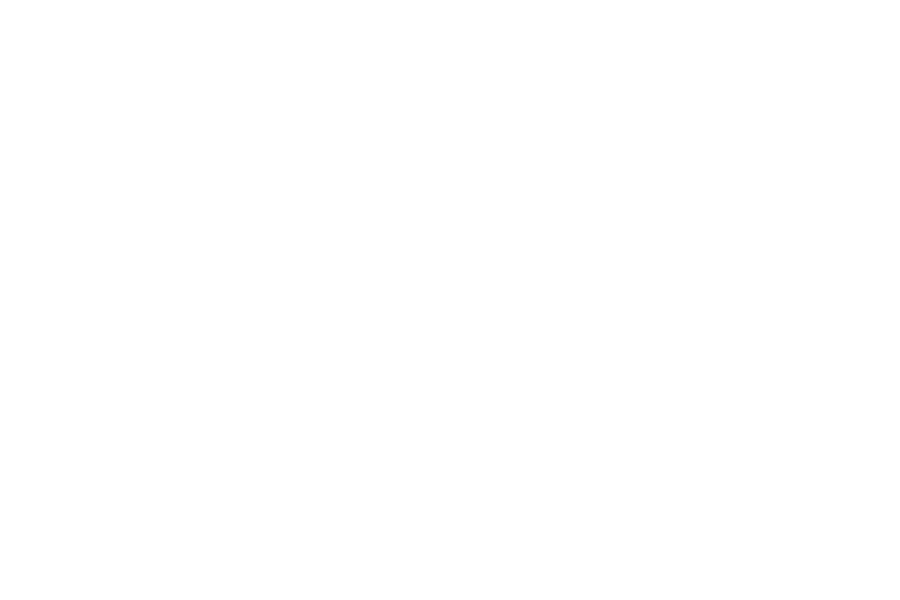

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import rc
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib notebook

#sns.set_style('whitegrid')
sns.set_style('dark')

iStartYear=2013

country1=[CarDataFrame(sales_ru), CarDataFrame(sales_ukraine), CarDataFrame(sales_poland)]
country2=[CarDataFrame(sales_germany), CarDataFrame(sales_uk), CarDataFrame(sales_france)]
country3=[CarDataFrame(sales_china), CarDataFrame(sales_usa), CarDataFrame(sales_japan)]
country4=[CarDataFrame(sales_india), CarDataFrame(sales_brazil), CarDataFrame(sales_sar)]


def plot_triple(frames, names, colors, mst=1e4):

    lst1=[pdf.to_datetime()[pdf['date'].dt.year >=iStartYear].groupby(pd.Grouper(key='date', freq='M'))['Count'].sum()/mst for pdf in frames]
    lst1[0].name=names[0]
    lst1[1].name=names[1]
    lst1[2].name=names[2]
    ax0, ax1, ax2=pd.concat(lst1, axis=1).plot.line(subplots=True, sharex=True, figsize=(9, 6), 
                                                    color=colors, rot=0, fontsize=8, lw=4, alpha=0.5, legend=False)

    ax0.set_title(names[0], fontsize=10, color=colors[0])
    pdfRu_trend=seasonal_decompose(lst1[0], model='additive', freq=12).trend
    pdfRu_trend.plot.line(ax=ax0, legend=False, color=colors[0], grid=True, fontsize=10, lw=1)


    ax1.set_title(names[1], fontsize=10, color=colors[1])
    pdfUkr_trend=seasonal_decompose(lst1[1], model='additive', freq=12).trend
    pdfUkr_trend.plot.line(ax=ax1, legend=False, color=colors[1], grid=True, fontsize=10, lw=1)

    ax2.set_title(names[2], fontsize=10, color=colors[2])
    pdfPol_trend=seasonal_decompose(lst1[2], model='additive', freq=12).trend
    pdfPol_trend.plot.line(ax=ax2, legend=False, color=colors[2], grid=True, fontsize=10, lw=1)

    ax0.tick_params(axis='both', which='major', labelsize=8)
    ax1.tick_params(axis='both', which='major', labelsize=8)
    ax2.tick_params(axis='both', which='major', labelsize=8)
    ax2.set_xlabel('Date', fontsize=8)
    plt.tight_layout()
    
    st=plt.gcf().suptitle('Car sales, {:.0f} cars'.format(mst), fontsize=12, color='maroon', weight='bold')
    plt.gcf().subplots_adjust(top=0.9)
    plt.show();
    return plt

plot_triple(country1, ['Russia', 'Ukraine', 'Poland'], ['navy', 'orange', 'darkred']).savefig(r'/home/egor/Изображения/car_sales_ru-ukr-pol.png')

NonGuiException: 

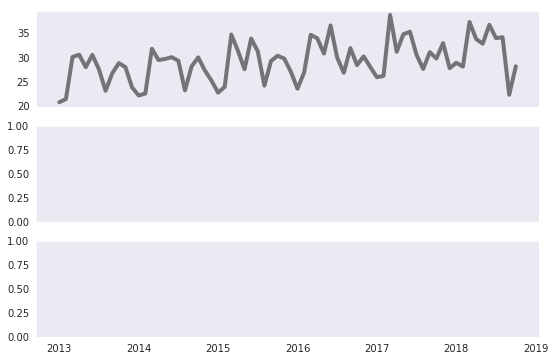

In [20]:
plot_triple(country2, ['Germany', 'United Kingdom', 'France'], ['black', 'red', 'blue']).savefig(r'/home/egor/Изображения/car_sales_ger_uk_fra.png')

In [ ]:
plot_triple(country3, ['China', 'USA', 'Japan'], ['goldenrod', 'royalblue', 'tomato']).savefig(r'/home/egor/Изображения/car_sales_ch_usa_jp.png')

In [ ]:
plot_triple(country4, ['India', 'Brazil', 'South Africa'], ['sienna', 'darkgreen', 'dimgrey']).savefig(r'/home/egor/Изображения/car_sales_ind_bra_sar.png')

## 2. Car production (https://auto.vercity.ru/statistics/production/)
###  For Russia

https://auto.vercity.ru/statistics/production/europe/2018/russia/

In [21]:
prod_df=pd.concat([GetYearsSalesData(Y, strSource=strCarProdsQ) for Y in range(2010, 2019)], axis=1) 

prod_df=prod_df.stack().reset_index().rename(columns={'level_0':'Model', 'level_1':'date', 0:'Count'})
prod_df['Count']=prod_df['Count'].apply(pd.to_numeric)

print(prod_df.head(10))

prod_df=prod_df[prod_df['Count']!=0]

#prod_df.to_sql('production_ru', con=conn, if_exists='replace', index=False)

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/russia/01-12/ ... Year 2010, country russia, reading (65, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/russia/01-12/ ... Year 2011, country russia, reading (62, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/russia/01-12/ ... Year 2012, country russia, reading (62, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/russia/01-12/ ... Year 2013, country russia, reading (61, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/russia/01-12/ ... Year 2014, country russia, reading (60, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/russia/01-12/ ... Year 2015, country russia, reading (57, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/russia/01-12/ ... Year 2016, country russia, reading (54, 13) items
Reading from  https:

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


  Model      date  Count
0   BAW  Jan-2010      0
1   BAW  Feb-2010      0
2   BAW  Mar-2010      0
3   BAW  Apr-2010      0
4   BAW  May-2010      0
5   BAW  Jun-2010      0
6   BAW  Jul-2010      0
7   BAW  Aug-2010      0
8   BAW  Sep-2010      0
9   BAW  Oct-2010      0


## For Ukraine

### Sales

In [22]:
sales_df_uk=pd.concat([GetYearsSalesData(Y, country='ukraine') for Y in range(2011, 2019)], axis=1) 

sales_df_uk=sales_df_uk.stack().reset_index().rename(columns={'level_0':'Model', 'level_1':'date', 0:'Count'})
sales_df_uk['Count']=sales_df_uk['Count'].apply(pd.to_numeric)

sales_df_uk=sales_df_uk[sales_df_uk['Count']!=0]

print(sales_df_uk.head(10))

sales_df_uk.to_sql('sales_ukraine', con=eng_co, if_exists='replace', index=False)

Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/ukraine/01-12/ ... Year 2011, country ukraine, reading (35, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/ukraine/01-12/ ... Year 2012, country ukraine, reading (34, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/ukraine/01-12/ ... Year 2013, country ukraine, reading (22, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/ukraine/01-12/ ... Year 2014, country ukraine, reading (25, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/ukraine/01-12/ ... Year 2015, country ukraine, reading (27, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/ukraine/01-12/ ... Year 2016, country ukraine, reading (30, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2017/ukraine/01-12/ ... Year 2017, country ukraine, reading (26, 13) items
Reading from  https://auto.vercity.ru/sta

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


### Production

In [23]:
prod_df_uk=pd.concat([GetYearsSalesData(Y, strSource=strCarProdsQ, country='ukraine') for Y in range(2010, 2019)], axis=1) 

prod_df_uk=prod_df_uk.stack().reset_index().rename(columns={'level_0':'Model', 'level_1':'date', 0:'Count'})
prod_df_uk['Count']=prod_df_uk['Count'].apply(pd.to_numeric)

prod_df_uk=prod_df_uk[prod_df_uk['Count']!=0]
print(prod_df_uk.head(10))
print(prod_df_uk['Model'].unique().tolist())
prod_df_uk.to_sql('production_ukraine', con=eng_co, if_exists='replace', index=False)

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/ukraine/01-12/ ... Year 2010, country ukraine, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/ukraine/01-12/ ... Year 2011, country ukraine, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/ukraine/01-12/ ... Year 2012, country ukraine, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/ukraine/01-12/ ... Year 2013, country ukraine, reading (11, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/ukraine/01-12/ ... Year 2014, country ukraine, reading (11, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/ukraine/01-12/ ... Year 2015, country ukraine, reading (10, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/ukraine/01-12/ ... Year 2016, country ukraine, reading (10, 13) items
Readin

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


## Germany

### Sales

In [24]:
sales_df_ger=pd.concat([GetYearsSalesData(Y, country='germany') for Y in range(2010, 2019)], axis=1) 

sales_df_ger=sales_df_ger.stack().reset_index().rename(columns={'level_0':'Model', 'level_1':'date', 0:'Count'})
sales_df_ger['Count']=sales_df_ger['Count'].apply(pd.to_numeric)

sales_df_ger=sales_df_ger[sales_df_ger['Count']!=0]

print(sales_df_ger.head(10))

sales_df_ger.to_sql('sales_germany', con=eng_co, if_exists='replace', index=False)

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/germany/01-12/ ... Year 2010, country germany, reading (51, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/germany/01-12/ ... Year 2011, country germany, reading (59, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/germany/01-12/ ... Year 2012, country germany, reading (58, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/germany/01-12/ ... Year 2013, country germany, reading (55, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/germany/01-12/ ... Year 2014, country germany, reading (63, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/germany/01-12/ ... Year 2015, country germany, reading (66, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/germany/01-12/ ... Year 2016, country germany, reading (62, 13) items
Reading from  https://auto.vercity.ru/sta

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


       Model      date  Count
0  AlfaRomeo  Jan-2010    493
1  AlfaRomeo  Feb-2010    530
2  AlfaRomeo  Mar-2010    513
3  AlfaRomeo  Apr-2010    642
4  AlfaRomeo  May-2010    503
5  AlfaRomeo  Jun-2010    832
6  AlfaRomeo  Jul-2010    771
7  AlfaRomeo  Aug-2010    798
8  AlfaRomeo  Sep-2010    865
9  AlfaRomeo  Oct-2010    963


### Production

In [25]:
prod_df_ger=pd.concat([GetYearsSalesData(Y, strSource=strCarProdsQ, country='germany') for Y in range(2010, 2019)], axis=1) 

prod_df_ger=prod_df_ger.stack().reset_index().rename(columns={'level_0':'Model', 'level_1':'date', 0:'Count'})
prod_df_ger['Count']=prod_df_ger['Count'].apply(pd.to_numeric)

prod_df_ger=prod_df_ger[prod_df_ger['Count']!=0]
print(prod_df_ger.head(10))
print(prod_df_ger['Model'].unique().tolist())
prod_df_ger.to_sql('production_germany', con=eng_co, if_exists='replace', index=False)

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/germany/01-12/ ... Year 2010, country germany, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/germany/01-12/ ... Year 2011, country germany, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/germany/01-12/ ... Year 2012, country germany, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/germany/01-12/ ... Year 2013, country germany, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/germany/01-12/ ... Year 2014, country germany, reading (13, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/germany/01-12/ ... Year 2015, country germany, reading (13, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/germany/01-12/ ... Year 2016, country germany, reading (13, 13) items
Readin

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


## France

### sales

In [26]:
sales_df_fra=pd.concat([GetYearsSalesData(Y, country='france') for Y in range(2010, 2019)], axis=1) 

sales_df_fra=sales_df_fra.stack().reset_index().rename(columns={'level_0':'Model', 'level_1':'date', 0:'Count'})
sales_df_fra['Count']=sales_df_fra['Count'].apply(pd.to_numeric)

sales_df_fra=sales_df_fra[sales_df_fra['Count']!=0]

print(sales_df_fra.head(10))

sales_df_fra.to_sql('sales_france', con=eng_co, if_exists='replace', index=False)

Reading from  https://auto.vercity.ru/statistics/sales/europe/2010/france/01-12/ ... Year 2010, country france, reading (43, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2011/france/01-12/ ... Year 2011, country france, reading (55, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2012/france/01-12/ ... Year 2012, country france, reading (57, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2013/france/01-12/ ... Year 2013, country france, reading (57, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2014/france/01-12/ ... Year 2014, country france, reading (55, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2015/france/01-12/ ... Year 2015, country france, reading (62, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/europe/2016/france/01-12/ ... Year 2016, country france, reading (60, 13) items
Reading from  https://auto.vercity.ru/statistics/sales/

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


       Model      date  Count
0  AlfaRomeo  Jan-2010    978
1  AlfaRomeo  Feb-2010    827
2  AlfaRomeo  Mar-2010    989
3  AlfaRomeo  Apr-2010    795
4  AlfaRomeo  May-2010   1027
5  AlfaRomeo  Jun-2010   1250
6  AlfaRomeo  Jul-2010    974
7  AlfaRomeo  Aug-2010    690
8  AlfaRomeo  Sep-2010   1653
9  AlfaRomeo  Oct-2010   1315


## Production

### Russia

In [27]:
prod_ru=crawldata(strCarProdsQ) #, country='ukraine')

prod_ru.to_sql('production_ru', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_ru.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/russia/01-12/ ... Year 2010, country russia, reading (65, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/russia/01-12/ ... Year 2011, country russia, reading (62, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/russia/01-12/ ... Year 2012, country russia, reading (62, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/russia/01-12/ ... Year 2013, country russia, reading (61, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/russia/01-12/ ... Year 2014, country russia, reading (60, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/russia/01-12/ ... Year 2015, country russia, reading (57, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/russia/01-12/ ... Year 2016, country russia, reading (54, 13) items
Reading from  https:

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



           Model      date  Count
4424  Volkswagen  Sep-2018  13642
2048       Haval  Sep-2018    101
824    Chevrolet  Sep-2018   2952
4532       Volvo  Sep-2018    521
1880     Genesis  Sep-2018    106
5492       КамАЗ  Sep-2018   3358
2900        Lada  Sep-2018  31482
4664        БЗКТ  Sep-2018     15
3740      Nissan  Sep-2018   7136
2276     Hyundai  Sep-2018   5484
608      ChangAn  Sep-2018     51
6140         УАЗ  Sep-2018   3645


### Ukraine

In [28]:
prod_ukraine=crawldata(strCarProdsQ, country='ukraine')

prod_ukraine.to_sql('production_ukraine', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_ukraine.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/ukraine/01-12/ ... Year 2010, country ukraine, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/ukraine/01-12/ ... Year 2011, country ukraine, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/ukraine/01-12/ ... Year 2012, country ukraine, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/ukraine/01-12/ ... Year 2013, country ukraine, reading (11, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/ukraine/01-12/ ... Year 2014, country ukraine, reading (11, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/ukraine/01-12/ ... Year 2015, country ukraine, reading (10, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/ukraine/01-12/ ... Year 2016, country ukraine, reading (10, 13) items
Readin

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



      Model      date  Count
629     БАЗ  Jun-2018     22
437   Skoda  Jun-2018    592
438   Skoda  Jul-2018    150
630     БАЗ  Jul-2018     20
846     ЗАЗ  Jul-2018      2
631     БАЗ  Aug-2018     18
847     ЗАЗ  Aug-2018      6
439   Skoda  Aug-2018    413
848     ЗАЗ  Sep-2018      2
440   Skoda  Sep-2018    476
632     БАЗ  Sep-2018     21
740  Богдан  Sep-2018      4


### Poland

In [29]:
prod_poland=crawldata(strCarProdsQ, country='poland')

prod_poland.to_sql('production_poland', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_poland.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/poland/01-12/ ... Year 2010, country poland, reading (7, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/poland/01-12/ ... Year 2011, country poland, reading (7, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/poland/01-12/ ... Year 2012, country poland, reading (7, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/poland/01-12/ ... Year 2013, country poland, reading (7, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/poland/01-12/ ... Year 2014, country poland, reading (6, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/poland/01-12/ ... Year 2015, country poland, reading (6, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/poland/01-12/ ... Year 2016, country poland, reading (6, 13) items
Reading from  https://auto.

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



          Model      date  Count
355      Lancia  Aug-2018   1378
655  Volkswagen  Aug-2018  12536
151        Fiat  Aug-2018  11958
547        Opel  Aug-2018   7947
656  Volkswagen  Sep-2018  13092
356      Lancia  Sep-2018   3626
548        Opel  Sep-2018   9207
152        Fiat  Sep-2018  12614
357      Lancia  Oct-2018   4823
549        Opel  Oct-2018   9136
153        Fiat  Oct-2018   9527
657  Volkswagen  Oct-2018  11646


### Czech Republic

In [30]:
prod_czech_republic=crawldata(strCarProdsQ, country='czech_republic')

prod_czech_republic.to_sql('production_czech', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_czech_republic.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/czech_republic/01-12/ ... Year 2010, country czech_republic, reading (12, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/czech_republic/01-12/ ... Year 2011, country czech_republic, reading (12, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/czech_republic/01-12/ ... Year 2012, country czech_republic, reading (12, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/czech_republic/01-12/ ... Year 2013, country czech_republic, reading (11, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/czech_republic/01-12/ ... Year 2014, country czech_republic, reading (11, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/czech_republic/01-12/ ... Year 2015, country czech_republic, reading (11, 13) items
Reading from  https://auto.vercity.ru/statistics/production/euro

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



        Model      date  Count
296   Hyundai  Sep-2018  25092
824     Skoda  Sep-2018  42991
716      Seat  Sep-2018   6354
188   Citroen  Sep-2018   6657
1100   Toyota  Sep-2018  10650
524   Peugeot  Sep-2018   7167
825     Skoda  Oct-2018  51511
297   Hyundai  Oct-2018  18259
717      Seat  Oct-2018   7657
189   Citroen  Oct-2018   5770
525   Peugeot  Oct-2018   5780
1101   Toyota  Oct-2018   7743


### Italy

In [31]:
prod_italy=crawldata(strCarProdsQ, country='italy')

prod_italy.to_sql('production_italy', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_italy.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/italy/01-12/ ... Year 2010, country italy, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/italy/01-12/ ... Year 2011, country italy, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/italy/01-12/ ... Year 2012, country italy, reading (13, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/italy/01-12/ ... Year 2013, country italy, reading (13, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/italy/01-12/ ... Year 2014, country italy, reading (13, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/italy/01-12/ ... Year 2015, country italy, reading (12, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/italy/01-12/ ... Year 2016, country italy, reading (11, 13) items
Reading from  https://auto.vercity

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



            Model      date  Count
104     AlfaRomeo  Sep-2018   5467
812          Jeep  Sep-2018  12439
1100     Maserati  Sep-2018   2994
920   Lamborghini  Sep-2018    365
921   Lamborghini  Oct-2018    350
381       Citroen  Oct-2018   6557
1209      Peugeot  Oct-2018   6944
1101     Maserati  Oct-2018   2910
597          Fiat  Oct-2018  32851
813          Jeep  Oct-2018  12368
105     AlfaRomeo  Oct-2018   6099
489       Ferrari  Oct-2018    850


### Slovakia

In [32]:
prod_slovakia=crawldata(strCarProdsQ, country='slovakia')

prod_slovakia.to_sql('production_slovakia', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_slovakia.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/slovakia/01-12/ ... Year 2010, country slovakia, reading (8, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/slovakia/01-12/ ... Year 2011, country slovakia, reading (8, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/slovakia/01-12/ ... Year 2012, country slovakia, reading (8, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/slovakia/01-12/ ... Year 2013, country slovakia, reading (7, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/slovakia/01-12/ ... Year 2014, country slovakia, reading (7, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/slovakia/01-12/ ... Year 2015, country slovakia, reading (7, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/slovakia/01-12/ ... Year 2016, country slovakia, reading (7, 13) items

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



          Model      date  Count
788  Volkswagen  Sep-2018  14399
104        Audi  Sep-2018   6415
680       Skoda  Sep-2018   2295
212     Citroen  Sep-2018  16131
356         Kia  Sep-2018  20969
573        Seat  Oct-2018    937
465     Peugeot  Oct-2018  15082
213     Citroen  Oct-2018  18719
681       Skoda  Oct-2018   2283
105        Audi  Oct-2018   7062
789  Volkswagen  Oct-2018  13102
357         Kia  Oct-2018  16320


### Slovenia

In [33]:
prod_slovenia=crawldata(strCarProdsQ, country='slovenia')

prod_slovenia.to_sql('production_slovenia', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_slovenia.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/slovenia/01-12/ ... Year 2010, country slovenia, reading (2, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/slovenia/01-12/ ... Year 2011, country slovenia, reading (2, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/slovenia/01-12/ ... Year 2012, country slovenia, reading (2, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/slovenia/01-12/ ... Year 2013, country slovenia, reading (2, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/slovenia/01-12/ ... Year 2014, country slovenia, reading (2, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/slovenia/01-12/ ... Year 2015, country slovenia, reading (2, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/slovenia/01-12/ ... Year 2016, country slovenia, reading (2, 13) items

### Belarus

In [34]:
prod_belarus=crawldata(strCarProdsQ, country='belarus')

prod_belarus.to_sql('production_belarus', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_belarus.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/belarus/01-12/ ... Year 2010, country belarus, reading (6, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/belarus/01-12/ ... Year 2011, country belarus, reading (6, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/belarus/01-12/ ... Year 2012, country belarus, reading (6, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/belarus/01-12/ ... Year 2013, country belarus, reading (6, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/belarus/01-12/ ... Year 2014, country belarus, reading (5, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/belarus/01-12/ ... Year 2015, country belarus, reading (4, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/belarus/01-12/ ... Year 2016, country belarus, reading (4, 13) items
Reading from 

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



     Model      date  Count
100  Geely  May-2018    205
316  БелАЗ  May-2018    100
101  Geely  Jun-2018    252
317  БелАЗ  Jun-2018    100
425    МАЗ  Jun-2018    810
102  Geely  Jul-2018    257
426    МАЗ  Jul-2018    770
318  БелАЗ  Jul-2018    100
427    МАЗ  Aug-2018    761
319  БелАЗ  Aug-2018     98
428    МАЗ  Sep-2018    732
320  БелАЗ  Sep-2018     90


### Germany

In [35]:
prod_germany=crawldata(strCarProdsQ, country='germany')

prod_germany.to_sql('production_germany', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_germany.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/germany/01-12/ ... Year 2010, country germany, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/germany/01-12/ ... Year 2011, country germany, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/germany/01-12/ ... Year 2012, country germany, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/germany/01-12/ ... Year 2013, country germany, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/germany/01-12/ ... Year 2014, country germany, reading (13, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/germany/01-12/ ... Year 2015, country germany, reading (13, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/germany/01-12/ ... Year 2016, country germany, reading (13, 13) items
Readin

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



              Model      date   Count
1328     Volkswagen  Sep-2018   61789
104            Audi  Sep-2018   26186
728   Mercedes-Benz  Sep-2018  133622
404            Ford  Sep-2018   47544
213             BMW  Oct-2018  115659
1221           Seat  Oct-2018      33
105            Audi  Oct-2018   33698
1005           Opel  Oct-2018   20407
405            Ford  Oct-2018   52593
729   Mercedes-Benz  Oct-2018  131713
1113        Porsche  Oct-2018    9141
1329     Volkswagen  Oct-2018  104918


### Spain

In [36]:
prod_spain=crawldata(strCarProdsQ, country='spain')

prod_spain.to_sql('production_spain', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_spain.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/spain/01-12/ ... Year 2010, country spain, reading (12, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/spain/01-12/ ... Year 2011, country spain, reading (11, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/spain/01-12/ ... Year 2012, country spain, reading (11, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/spain/01-12/ ... Year 2013, country spain, reading (11, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/spain/01-12/ ... Year 2014, country spain, reading (11, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/spain/01-12/ ... Year 2015, country spain, reading (11, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/spain/01-12/ ... Year 2016, country spain, reading (11, 13) items
Reading from  https://auto.vercity

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



              Model      date  Count
752            Opel  Sep-2018  39703
537   Mercedes-Benz  Oct-2018  13248
1077           Seat  Oct-2018  23861
1197     Volkswagen  Oct-2018  20877
321            Ford  Oct-2018  24506
753            Opel  Oct-2018  27949
429           Iveco  Oct-2018   3765
969         Renault  Oct-2018  26900
105            Audi  Oct-2018   1923
645          Nissan  Oct-2018   6493
213         Citroen  Oct-2018  32834
861         Peugeot  Oct-2018   9032


### France

In [37]:
prod_france=crawldata(strCarProdsQ, country='france')

prod_france.to_sql('production_france', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_france.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/france/01-12/ ... Year 2010, country france, reading (15, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/france/01-12/ ... Year 2011, country france, reading (15, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/france/01-12/ ... Year 2012, country france, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/france/01-12/ ... Year 2013, country france, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/france/01-12/ ... Year 2014, country france, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/france/01-12/ ... Year 2015, country france, reading (14, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/france/01-12/ ... Year 2016, country france, reading (14, 13) items
Reading from  https:

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



              Model      date  Count
104          Alpine  Sep-2018     50
1461         Toyota  Oct-2018  23558
1161        Renault  Oct-2018  39872
513            Fiat  Oct-2018   2813
729   Mercedes-Benz  Oct-2018   2513
1053        Peugeot  Oct-2018  75708
321              DS  Oct-2018   3165
213         Citroen  Oct-2018   6034
945            Opel  Oct-2018  10275
1353          Smart  Oct-2018   8360
837          Nissan  Oct-2018   5549
105          Alpine  Oct-2018    123


### United Kingdom

In [38]:
prod_uk=crawldata(strCarProdsQ, country='united_kingdom')

prod_uk.to_sql('production_uk', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_uk.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/united_kingdom/01-12/ ... Year 2010, country united_kingdom, reading (27, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/united_kingdom/01-12/ ... Year 2011, country united_kingdom, reading (25, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/united_kingdom/01-12/ ... Year 2012, country united_kingdom, reading (23, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/united_kingdom/01-12/ ... Year 2013, country united_kingdom, reading (23, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/united_kingdom/01-12/ ... Year 2014, country united_kingdom, reading (22, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/united_kingdom/01-12/ ... Year 2015, country united_kingdom, reading (22, 13) items
Reading from  https://auto.vercity.ru/statistics/production/euro

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



            Model      date  Count
1629      Minerva  Oct-2018  16330
1509      McLaren  Oct-2018    325
1953         Opel  Oct-2018  14009
1113    LandRover  Oct-2018  34905
2217  Rolls-Royce  Oct-2018    275
1737       Morgan  Oct-2018     55
777        Jaguar  Oct-2018   5576
897          LEVC  Oct-2018    185
189   AstonMartin  Oct-2018    350
2325       Toyota  Oct-2018   8793
297       Bentley  Oct-2018   1050
669      Infiniti  Oct-2018   1228


### China

In [49]:
prod_china=crawldata(strCarProdsQ, country='china')

prod_china.to_sql('production_china', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_china.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/china/01-12/ ... Year 2010, country china, reading (126, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/china/01-12/ ... Year 2011, country china, reading (123, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/china/01-12/ ... Year 2012, country china, reading (122, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/china/01-12/ ... Year 2013, country china, reading (119, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/china/01-12/ ... Year 2014, country china, reading (118, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/china/01-12/ ... Year 2015, country china, reading (118, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/china/01-12/ ... Year 2016, country china, reading (117, 13) items
Reading from  https://auto.

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



              Model      date   Count
428            BAIC  Sep-2018       3
2636          Cowin  Sep-2018     978
7964          Lifan  Sep-2018    2299
4544   GoldenDragon  Sep-2018    2282
3680            FAW  Sep-2018   34997
5144         Hawtai  Sep-2018   13891
5612          Honda  Sep-2018  129006
11840          XCMG  Sep-2018     993
5936        Huasong  Sep-2018     391
4004           Ford  Sep-2018   36022
10544       Sunlong  Sep-2018     270
7640       LYNK&Co;  Sep-2018   14634


### Japan

In [50]:
prod_japan=crawldata(strCarProdsQ, country='japan')

prod_japan.to_sql('production_japan', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_japan.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/japan/01-12/ ... Year 2010, country japan, reading (19, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/japan/01-12/ ... Year 2011, country japan, reading (18, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/japan/01-12/ ... Year 2012, country japan, reading (16, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/japan/01-12/ ... Year 2013, country japan, reading (16, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/japan/01-12/ ... Year 2014, country japan, reading (16, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/japan/01-12/ ... Year 2015, country japan, reading (16, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/japan/01-12/ ... Year 2016, country japan, reading (15, 13) items
Reading from  https://auto.vercity

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



           Model      date   Count
1099  Mitsubishi  Aug-2018   31067
1628      Toyota  Sep-2018  191311
200     Daihatsu  Sep-2018   43676
1412      Subaru  Sep-2018   61053
1520      Suzuki  Sep-2018   64859
1100  Mitsubishi  Sep-2018   48330
992        Mazda  Sep-2018   78558
1208      Nissan  Sep-2018   75952
884        Lexus  Sep-2018   45478
656     Infiniti  Sep-2018    8219
308         Fiat  Sep-2018     273
548        Honda  Sep-2018   70420


### India

In [51]:
prod_india=crawldata(strCarProdsQ, country='india')

prod_india.to_sql('production_india', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_india.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/india/01-12/ ... Year 2010, country india, reading (32, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/india/01-12/ ... Year 2011, country india, reading (32, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/india/01-12/ ... Year 2012, country india, reading (31, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/india/01-12/ ... Year 2013, country india, reading (31, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/india/01-12/ ... Year 2014, country india, reading (31, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/india/01-12/ ... Year 2015, country india, reading (31, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/india/01-12/ ... Year 2016, country india, reading (30, 13) items
Reading from  https://auto.vercity

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



           Model      date  Count
1076        Ford  Sep-2018  18377
2360      Nissan  Sep-2018   5875
860         Fiat  Sep-2018     73
536    Chevrolet  Sep-2018   5894
2792   SsangYong  Sep-2018    113
3332       Volvo  Sep-2018     38
644       Datsun  Sep-2018   2637
3116      Toyota  Sep-2018  13584
1904        Jeep  Sep-2018   1616
3224  Volkswagen  Sep-2018   6784
752       Eicher  Sep-2018   6553
2468     Piaggio  Sep-2018    129


### South Korea

In [52]:
prod_south_korea=crawldata(strCarProdsQ, country='south_korea')

prod_south_korea.to_sql('production_south_korea', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_south_korea.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/south_korea/01-12/ ... Year 2010, country south_korea, reading (9, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/south_korea/01-12/ ... Year 2011, country south_korea, reading (9, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/south_korea/01-12/ ... Year 2012, country south_korea, reading (9, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/south_korea/01-12/ ... Year 2013, country south_korea, reading (9, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/south_korea/01-12/ ... Year 2014, country south_korea, reading (9, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/south_korea/01-12/ ... Year 2015, country south_korea, reading (9, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/south_korea/01-12/ ... Year 2016, 

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



         Model      date   Count
835    Samsung  Aug-2018    6449
943  SsangYong  Aug-2018   10179
727     Nissan  Aug-2018    4991
295     Daewoo  Aug-2018    1252
296     Daewoo  Sep-2018    1012
404    Genesis  Sep-2018    7312
728     Nissan  Sep-2018    6246
620        Kia  Sep-2018   98688
188  Chevrolet  Sep-2018   14270
944  SsangYong  Sep-2018   10767
836    Samsung  Sep-2018    7959
512    Hyundai  Sep-2018  127635


### Brazil

In [53]:
prod_brazil=crawldata(strCarProdsQ, country='brazil')

prod_brazil.to_sql('production_brazil', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_brazil.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/brazil/01-12/ ... Year 2010, country brazil, reading (30, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/brazil/01-12/ ... Year 2011, country brazil, reading (30, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/brazil/01-12/ ... Year 2012, country brazil, reading (29, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/brazil/01-12/ ... Year 2013, country brazil, reading (28, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/brazil/01-12/ ... Year 2014, country brazil, reading (28, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/brazil/01-12/ ... Year 2015, country brazil, reading (27, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/brazil/01-12/ ... Year 2016, country brazil, reading (27, 13) items
Reading from  https:

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



           Model      date  Count
188         Audi  Sep-2018    179
296          BMW  Sep-2018    713
2288     Renault  Sep-2018  21454
860         Ford  Sep-2018  18258
2072      Nissan  Sep-2018   9169
2696     Troller  Sep-2018    115
752         Fiat  Sep-2018  24005
1328       Iveco  Sep-2018    314
404        Chery  Sep-2018    750
2588      Toyota  Sep-2018  12878
1544   LandRover  Sep-2018    325
2804  Volkswagen  Sep-2018  36274


### United States

In [54]:
prod_usa=crawldata(strCarProdsQ, country='united_states')

prod_usa.to_sql('production_usa', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_usa.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/united_states/01-12/ ... Year 2010, country united_states, reading (44, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/united_states/01-12/ ... Year 2011, country united_states, reading (42, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/united_states/01-12/ ... Year 2012, country united_states, reading (38, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/united_states/01-12/ ... Year 2013, country united_states, reading (38, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/united_states/01-12/ ... Year 2014, country united_states, reading (36, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/united_states/01-12/ ... Year 2015, country united_states, reading (36, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/unit

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



        Model      date   Count
3212      Ram  Sep-2018   54002
2984     Opel  Sep-2018     214
320     Buick  Sep-2018    5315
1364    Honda  Sep-2018   93778
2120      Kia  Sep-2018   20400
1496  Hyundai  Sep-2018   30800
3524    Tesla  Sep-2018   35263
1916     Jeep  Sep-2018   67942
848      Ford  Sep-2018  179551
1256   Holden  Sep-2018     705
2876   Nissan  Sep-2018   57100
3632   Toyota  Sep-2018   93297


### Mexico

In [55]:
prod_mexico=crawldata(strCarProdsQ, country='mexico')

prod_mexico.to_sql('production_mexico', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_mexico.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/mexico/01-12/ ... Year 2010, country mexico, reading (34, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/mexico/01-12/ ... Year 2011, country mexico, reading (33, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/mexico/01-12/ ... Year 2012, country mexico, reading (30, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/mexico/01-12/ ... Year 2013, country mexico, reading (19, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/mexico/01-12/ ... Year 2014, country mexico, reading (19, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/mexico/01-12/ ... Year 2015, country mexico, reading (19, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/mexico/01-12/ ... Year 2016, country mexico, reading (19, 13) items
Reading from  https:

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



           Model      date  Count
956        Honda  Sep-2018   3589
2360      Toyota  Sep-2018  18410
704         Ford  Sep-2018  19302
488        Dodge  Sep-2018  27704
1172    Infiniti  Sep-2018   3196
1604     Lincoln  Sep-2018   3111
104         Audi  Sep-2018   9758
1064     Hyundai  Sep-2018   6159
812          GMC  Sep-2018  25707
308    Chevrolet  Sep-2018  49303
2468  Volkswagen  Sep-2018  29219
1496         Kia  Sep-2018  22141


### South Africa

In [56]:
prod_sar=crawldata(strCarProdsQ, country='south_africa')

prod_sar.to_sql('production_sar', con=eng_co, if_exists=update_behaviour, index=False)

print(prod_sar.tail(12))

Reading from  https://auto.vercity.ru/statistics/production/europe/2010/south_africa/01-12/ ... Year 2010, country south_africa, reading (12, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2011/south_africa/01-12/ ... Year 2011, country south_africa, reading (12, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2012/south_africa/01-12/ ... Year 2012, country south_africa, reading (12, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2013/south_africa/01-12/ ... Year 2013, country south_africa, reading (12, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2014/south_africa/01-12/ ... Year 2014, country south_africa, reading (12, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2015/south_africa/01-12/ ... Year 2015, country south_africa, reading (12, 13) items
Reading from  https://auto.vercity.ru/statistics/production/europe/2016/south_africa/01-

/home/egor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



              Model      date  Count
427            Ford  Aug-2018   8134
1292     Volkswagen  Sep-2018  12510
860   Mercedes-Benz  Sep-2018  11493
968          Nissan  Sep-2018   2908
212         Beijing  Sep-2018    357
104             BMW  Sep-2018   6001
536         Hyundai  Sep-2018    276
644           Isuzu  Sep-2018   1136
752           Mazda  Sep-2018     28
428            Ford  Sep-2018   7021
1184         Toyota  Sep-2018  11740
1076           Tata  Sep-2018     63
